## this gets the data into csv format

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#this is commented out because it takes forever and I will just provide the filtered files. 
#however it is good to see how we did this

#open('filtered_data\q1_commit_messages_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q1_commit_messages.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q2_commit_dates_epoch_timestamp_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q2_commit_dates_epoch_timestamp.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q3_author_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q3_author_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q4_committer_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q4_committer_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q5_all_changed_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q5_all_changed_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q6_deleted_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q6_deleted_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q7_added_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q7_added_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q8_modified_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q8_modified_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q10_commit_count_by_project_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q10_commit_count_by_project.txt',encoding="utf8") if 'commit_log' in line)

## here we bring the filtered files in and merge the first set into one dataframe

In [3]:
messages = pd.read_csv('filtered_data/q1_commit_messages_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','message'])
timestamps = pd.read_csv('filtered_data/q2_commit_dates_epoch_timestamp_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','timestamp'])
authors = pd.read_csv('filtered_data/q3_author_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','author_name','commit_id'])
committers = pd.read_csv('filtered_data/q4_committer_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','committer_name'])

In [4]:
#merge all the message related files together
merge1 = pd.merge(messages,timestamps, on=['project_id','commit_id'])
merge2 = pd.merge(merge1, authors, on=['project_id','commit_id'])
merged_data = pd.merge(merge2,committers, on=['project_id','commit_id'])

In [5]:
#drop any rows that dont have a message because we dont need them
merged_data.dropna(subset=['message'], inplace=True)

In [6]:
#spit out all the messages to a file alone for processing by sentistrength
merged_data.message.to_csv('sentistrength_run/messages_only.csv', header=False, index=False)

## here, we manually run the sentistrength tool on the messages_only file, which produces the messages_only_results file which we can then merge with the main dataframe

In [7]:
#bring the strengths data in from the sentistrength results file
strengths = pd.read_csv('sentistrength_run/messages_only_results.txt', usecols=[1,2], sep='\t', dtype=str, names=['positive_strength','negative_strength'])

In [8]:
#merge the strengths with the main dataframe
merged_data.reset_index(drop=True, inplace=True)
commit_messages_final = pd.concat([merged_data,strengths],axis=1)

In [9]:
#convert the timestamp to date and add a day of week field
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].astype(str)
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].str[:10]
commit_messages_final['timestamp'] = pd.to_datetime(commit_messages_final['timestamp'],unit='s',errors='coerce')
commit_messages_final['day_of_week'] = commit_messages_final['timestamp'].dt.weekday_name

## done with commit messages, moving on to changed files

In [10]:
#Bring in all the file related stuff
all_changes = pd.read_csv('filtered_data/q5_all_changed_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
deletes = pd.read_csv('filtered_data/q6_deleted_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
adds = pd.read_csv('filtered_data/q7_added_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
modifies = pd.read_csv('filtered_data/q8_modified_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])

In [11]:
#tag the deletes
merge_deletes = pd.merge(all_changes, deletes, on=['commit_id','filepath'], how='left', indicator='modif')
merge_deletes['modif'] = np.where(merge_deletes.modif == 'both', 'Delete', '')

In [12]:
#tag the adds
merge_adds = pd.merge(all_changes, adds, on=['commit_id','filepath'], how='left', indicator='modif')
merge_adds['modif'] = np.where(merge_adds.modif == 'both', 'Add', '')

In [13]:
#tag the modifies
merge_modifies = pd.merge(all_changes, modifies, on=['commit_id','filepath'], how='left', indicator='modif')
merge_modifies['modif'] = np.where(merge_modifies.modif == 'both', 'Modify', '')

In [14]:
#merge the deletes and adds tag frames together
temp_files_merge = pd.merge(merge_deletes, merge_adds, on=['commit_id','filepath'])

In [15]:
#squash down the columns in the delete/add frame so the tags are in the same column
temp_files_merge['modif'] = temp_files_merge['modif_x'].where(temp_files_merge['modif_x'] != '', temp_files_merge['modif_y'])
temp_files_merge = temp_files_merge.drop(['modif_x','modif_y'],axis=1)

In [16]:
#merge the delete/add frame and the modify frame together
temp_files_merge2 = pd.merge(temp_files_merge, merge_modifies, on=['commit_id','filepath'])

In [17]:
#squash down the columns in the final frame so the all tags are in the same column
temp_files_merge2['modification'] = temp_files_merge2['modif_x'].where(temp_files_merge2['modif_x'] != '', temp_files_merge2['modif_y'])
files_changed_final = temp_files_merge2.drop(['modif_x','modif_y'],axis=1)

##  here are the final pandas dataframes:

In [18]:
commit_messages_final.head()

,project_id,commit_id,message,timestamp,author_name,committer_name,positive_strength,negative_strength,day_of_week
0,10000244,0515c7d89f97bf7f1e488ac39dcc8fe1ee79f605,photo in progress,2013-05-11 15:52:20,syhw,syhw,1,-1,Saturday
1,10000244,07abeaf9bd85eb77f0774607161a7ccb3ed8dff3,stashing,2013-05-12 09:29:50,syhw,syhw,1,-1,Sunday
2,10000244,11f46d585bfc263e11b0556566559e6513cca0e4,R,2013-05-12 12:10:17,syhw,syhw,1,-1,Sunday
3,10000244,25ffeb626cd9146c483c6144b8208b5bd6cf26c4,"merged photo (working) with master, see TODOs...",2013-05-12 07:18:18,syhw,syhw,1,-1,Sunday
4,10000244,33ac9b6d9da4234c93ae3d9e0d7b0f41edb99d8a,Request task,2013-05-12 10:01:57,syhw,syhw,1,-1,Sunday


In [19]:
files_changed_final.head()

,commit_id,filepath,modification
0,000e3673387b662e32f1037eeaea2aa29b630448,Sources/Internal/Platform/TemplateMacOS/MainW...,Modify
1,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
2,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
3,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
4,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete


# Analysis

### RQ1

In [20]:
#compute final sentiment value from sum of positive and negative
commit_messages_final['final_sentiment'] = pd.to_numeric(commit_messages_final['positive_strength']) + pd.to_numeric(commit_messages_final['negative_strength'])

In [21]:
#count the number of commits for each sentiment level
commits_by_sentiment = commit_messages_final.groupby(['final_sentiment']).count().reset_index()
commits_by_sentiment = commits_by_sentiment[['final_sentiment','project_id']]
commits_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)

In [22]:
#bin the commits by positive, negative, and neutral sentiment
commits_by_sentiment['percent_of_total'] = commits_by_sentiment['count'].divide(len(commit_messages_final)).multiply(100)
commits_by_sentiment['bin'] = pd.cut(commits_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
commits_by_sentiment

,final_sentiment,count,percent_of_total,bin
0,-4,47,0.002086,negative
1,-3,1819,0.080736,negative
2,-2,31340,1.391018,negative
3,-1,262278,11.641144,negative
4,0,1821462,80.845139,neutral
5,1,125868,5.586620,positive
6,2,9911,0.439897,positive
7,3,295,0.013094,positive
8,4,6,0.000266,positive


In [23]:
#sum up the total percent of each bin
commits_by_sentiment_binned = commits_by_sentiment.groupby(['bin']).sum().reset_index()
commits_by_sentiment_binned = commits_by_sentiment_binned[['bin','count','percent_of_total']]
commits_by_sentiment_binned

,bin,count,percent_of_total
0,negative,295484,13.114984
1,neutral,1821462,80.845139
2,positive,136080,6.039877


In [24]:
commits_by_project = commit_messages_final.groupby(['project_id']).count().reset_index()

In [25]:
commits_by_project = commits_by_project[['project_id','commit_id']]
commits_by_project.rename(columns={'commit_id':'count'}, inplace=True)
commits_by_project.sort_values(['count'], inplace=True)

In [26]:
commits_by_project.to_csv('commits_by_project_sorted.csv', sep='\t', encoding='utf-8')

### manually obtained large, average and low groups by examining file

In [27]:
largelist = ['12496978','10613094','5153143','7785050','1968812']
avglist = ['2424377','5256179','365893','6719407','13010741']
lowlist = ['10453653','10530838','11416657','4067771','1571039']

In [28]:
large_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(largelist)]
avg_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(avglist)]
low_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(lowlist)]

In [29]:
#get bin percentages for large projects
large_by_sentiment = large_projects.groupby(['final_sentiment']).count().reset_index()
large_by_sentiment = large_by_sentiment[['final_sentiment','project_id']]
large_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
large_by_sentiment['percent_of_total'] = large_by_sentiment['count'].divide(len(large_projects)).multiply(100)
large_by_sentiment['bin'] = pd.cut(large_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
large_by_sentiment_binned = large_by_sentiment.groupby(['bin']).sum().reset_index()
large_by_sentiment_binned = large_by_sentiment_binned[['bin','count','percent_of_total']]
large_by_sentiment_binned

,bin,count,percent_of_total
0,negative,8568,15.728604
1,neutral,42061,77.212982
2,positive,3845,7.058413


In [30]:
#get bin percentages for average projects
avg_by_sentiment = avg_projects.groupby(['final_sentiment']).count().reset_index()
avg_by_sentiment = avg_by_sentiment[['final_sentiment','project_id']]
avg_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
avg_by_sentiment['percent_of_total'] = avg_by_sentiment['count'].divide(len(avg_projects)).multiply(100)
avg_by_sentiment['bin'] = pd.cut(avg_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
avg_by_sentiment_binned = avg_by_sentiment.groupby(['bin']).sum().reset_index()
avg_by_sentiment_binned = avg_by_sentiment_binned[['bin','count','percent_of_total']]
avg_by_sentiment_binned

,bin,count,percent_of_total
0,negative,3970,17.082616
1,neutral,17987,77.396730
2,positive,1283,5.520654


In [31]:
#get bin percentages for low projects
low_by_sentiment = low_projects.groupby(['final_sentiment']).count().reset_index()
low_by_sentiment = low_by_sentiment[['final_sentiment','project_id']]
low_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
low_by_sentiment['percent_of_total'] = low_by_sentiment['count'].divide(len(low_projects)).multiply(100)
low_by_sentiment['bin'] = pd.cut(low_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
low_by_sentiment_binned = low_by_sentiment.groupby(['bin']).sum().reset_index()
low_by_sentiment_binned = low_by_sentiment_binned[['bin','count','percent_of_total']]
low_by_sentiment_binned

,bin,count,percent_of_total
0,negative,606,9.724005
1,neutral,5306,85.141207
2,positive,320,5.134788


## RQ2

### Sort out day of week data for all commits

In [32]:
##create the bins per weekday
weekdays = commit_messages_final.groupby(['day_of_week',pd.cut(commit_messages_final.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays = weekdays.size().unstack()
weekdays.columns = [''.join(col).strip() for col in weekdays.columns.values]
weekdays.reset_index(inplace=True)

#get the totals again
weekdays['total'] = weekdays['negative'] + weekdays['neutral'] + weekdays['positive']
weekdays['negative_pct'] = weekdays['negative'].divide(weekdays['total']).multiply(100)
weekdays['neutral_pct'] = weekdays['neutral'].divide(weekdays['total']).multiply(100)
weekdays['positive_pct'] = weekdays['positive'].divide(weekdays['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays['day_of_week'].map(mapping)
weekdays = weekdays.iloc[key.argsort()].set_index('day_of_week')
weekdays.columns = [''.join(col).strip() for col in weekdays.columns.values]
weekdays.reset_index(inplace=True)
weekdays

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,44670,278781,20354,343805,12.992830,81.086953,5.920216
1,Tuesday,52833,315346,23561,391740,13.486751,80.498800,6.014448
2,Wednesday,52230,320689,24394,397313,13.145807,80.714449,6.139744
3,Thursday,50815,305385,22884,379084,13.404681,80.558662,6.036657
4,Friday,46786,284494,21198,352478,13.273453,80.712555,6.013992
5,Saturday,23342,151805,11362,186509,12.515214,81.392855,6.091931
6,Sunday,22738,155188,11491,189417,12.004202,81.929288,6.066509


### Sort out day of week data for large commits

In [33]:
##create the bins per weekday
weekdays_large = large_projects.groupby(['day_of_week',pd.cut(large_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_large = weekdays_large.size().unstack()
weekdays_large.columns = [''.join(col).strip() for col in weekdays_large.columns.values]
weekdays_large.reset_index(inplace=True)

#get the totals again
weekdays_large['total'] = weekdays_large['negative'] + weekdays_large['neutral'] + weekdays_large['positive']
weekdays_large['negative_pct'] = weekdays_large['negative'].divide(weekdays_large['total']).multiply(100)
weekdays_large['neutral_pct'] = weekdays_large['neutral'].divide(weekdays_large['total']).multiply(100)
weekdays_large['positive_pct'] = weekdays_large['positive'].divide(weekdays_large['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_large['day_of_week'].map(mapping)
weekdays_large = weekdays_large.iloc[key.argsort()].set_index('day_of_week')
weekdays_large.columns = [''.join(col).strip() for col in weekdays_large.columns.values]
weekdays_large.reset_index(inplace=True)
weekdays_large

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,1255,6850,626,8731,14.374069,78.456076,7.169855
1,Tuesday,1684,7967,760,10411,16.175199,76.524830,7.299971
2,Wednesday,1853,8541,833,11227,16.504854,76.075532,7.419613
3,Thursday,1656,8052,744,10452,15.843858,77.037887,7.118255
4,Friday,1434,7371,598,9403,15.250452,78.389876,6.359672
5,Saturday,376,1779,161,2316,16.234888,76.813472,6.951641
6,Sunday,310,1501,123,1934,16.028956,77.611169,6.359876


### Sort out day of week data for average commits

In [34]:
##create the bins per weekday
weekdays_avg = avg_projects.groupby(['day_of_week',pd.cut(avg_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_avg = weekdays_avg.size().unstack()
weekdays_avg.columns = [''.join(col).strip() for col in weekdays_avg.columns.values]
weekdays_avg.reset_index(inplace=True)

#get the totals again
weekdays_avg['total'] = weekdays_avg['negative'] + weekdays_avg['neutral'] + weekdays_avg['positive']
weekdays_avg['negative_pct'] = weekdays_avg['negative'].divide(weekdays_avg['total']).multiply(100)
weekdays_avg['neutral_pct'] = weekdays_avg['neutral'].divide(weekdays_avg['total']).multiply(100)
weekdays_avg['positive_pct'] = weekdays_avg['positive'].divide(weekdays_avg['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_avg['day_of_week'].map(mapping)
weekdays_avg = weekdays_avg.iloc[key.argsort()].set_index('day_of_week')
weekdays_avg.columns = [''.join(col).strip() for col in weekdays_avg.columns.values]
weekdays_avg.reset_index(inplace=True)
weekdays_avg

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,622,2813,215,3650,17.041096,77.068493,5.890411
1,Tuesday,757,3395,258,4410,17.165533,76.984127,5.850340
2,Wednesday,734,3294,229,4257,17.242189,77.378436,5.379375
3,Thursday,687,3333,218,4238,16.210477,78.645588,5.143936
4,Friday,714,3100,231,4045,17.651422,76.637824,5.710754
5,Saturday,229,1005,66,1300,17.615385,77.307692,5.076923
6,Sunday,227,1047,66,1340,16.940299,78.134328,4.925373


### Sort out day of week data for low commits

In [35]:
##create the bins per weekday
weekdays_low = low_projects.groupby(['day_of_week',pd.cut(low_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_low = weekdays_low.size().unstack()
weekdays_low.columns = [''.join(col).strip() for col in weekdays_low.columns.values]
weekdays_low.reset_index(inplace=True)

#get the totals again
weekdays_low['total'] = weekdays_low['negative'] + weekdays_low['neutral'] + weekdays_low['positive']
weekdays_low['negative_pct'] = weekdays_low['negative'].divide(weekdays_low['total']).multiply(100)
weekdays_low['neutral_pct'] = weekdays_low['neutral'].divide(weekdays_low['total']).multiply(100)
weekdays_low['positive_pct'] = weekdays_low['positive'].divide(weekdays_low['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_low['day_of_week'].map(mapping)
weekdays_low = weekdays_low.iloc[key.argsort()].set_index('day_of_week')
weekdays_low.columns = [''.join(col).strip() for col in weekdays_low.columns.values]
weekdays_low.reset_index(inplace=True)
weekdays_low

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,115,1024,63,1202,9.567388,85.191348,5.241265
1,Tuesday,104,933,50,1087,9.567617,85.832567,4.599816
2,Wednesday,113,899,48,1060,10.660377,84.811321,4.528302
3,Thursday,102,938,58,1098,9.289617,85.428051,5.282332
4,Friday,95,848,48,991,9.586276,85.570131,4.843592
5,Saturday,33,315,27,375,8.800000,84.000000,7.200000
6,Sunday,44,349,26,419,10.501193,83.293556,6.205251


### graphing

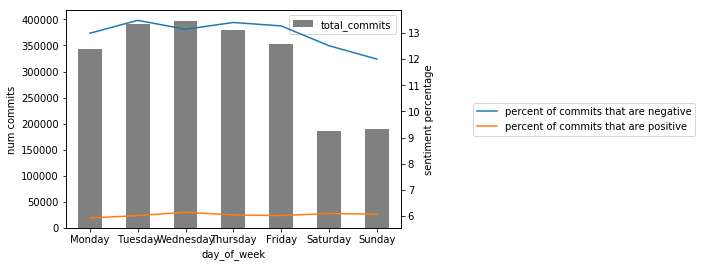

In [36]:
#graphing the data for all commits
ax = weekdays.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

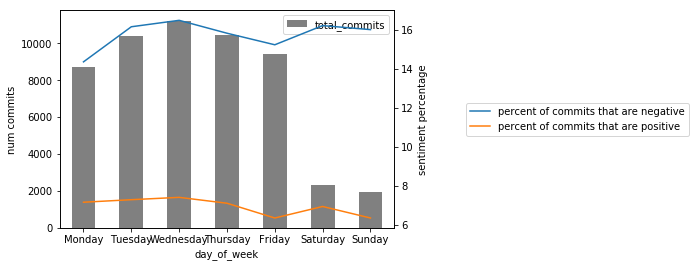

In [37]:
#graphing the data for large commits
ax = weekdays_large.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_large['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_large['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

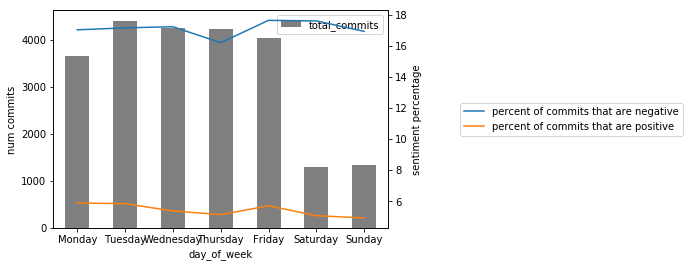

In [38]:
#graphing the data for average commits
ax = weekdays_avg.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_avg['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_avg['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

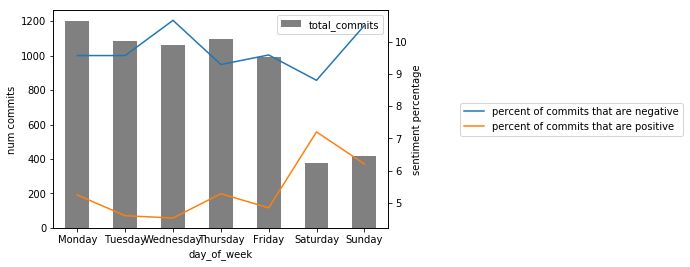

In [39]:
#graphing the data for low commits
ax = weekdays_low.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_low['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_low['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

## RQ3
Is there a correlation between the number of changed files and developer sentiment? 

In [40]:
files_changed_count = files_changed_final.groupby('commit_id').count().reset_index()
files_changed_count = files_changed_count[['commit_id', 'modification']]
files_changed_count.commit_id = files_changed_count.commit_id.astype(str)
files_changed_count.commit_id = files_changed_count.commit_id.str.strip()

In [41]:
files_changed_count.head()

,commit_id,modification
0,000e3673387b662e32f1037eeaea2aa29b630448,13
1,000e722626473ce76fcc2a604b1ef8ba7860ef7e,2
2,0013e3a3a6ec30cd05d17b1d9597617866254d43,1
3,00196d38b331102892a87d0c33fa5f7d9f6d3958,1
4,001a91d48e1cbaaf3f139f73c06e68e95008b160,8


In [42]:
df_sentiments_hashes = commit_messages_final[['commit_id','final_sentiment']]
df_sentiments_hashes.dropna(inplace=True)
df_sentiments_hashes.commit_id = df_sentiments_hashes.commit_id.astype(str)
df_sentiments_hashes.commit_id = df_sentiments_hashes.commit_id.str.strip()

In [43]:
df_sentiments_hashes.head()

,commit_id,final_sentiment
0,0515c7d89f97bf7f1e488ac39dcc8fe1ee79f605,0
1,07abeaf9bd85eb77f0774607161a7ccb3ed8dff3,0
2,11f46d585bfc263e11b0556566559e6513cca0e4,0
3,25ffeb626cd9146c483c6144b8208b5bd6cf26c4,0
4,33ac9b6d9da4234c93ae3d9e0d7b0f41edb99d8a,0


##### Merge Dataframes:

In [44]:
files_changed_count_merged = files_changed_count.merge(df_sentiments_hashes,on='commit_id', how='left')

In [45]:
files_changed_count_merged.sort_values(['modification'], ascending=False).head(20)

,commit_id,modification,final_sentiment
4219,48c2b2f6590ecaeb22432332449be22cc3ef7257,7684,0
12541,d71c50d4458200a37ab2046f744be6da37845179,7494,0
5272,5a19809e53be3594bbf4a8c5dfa28f329c7d8ea6,7193,0
10137,adc4a2d8199f121fb23105e1241436f3cf9decf1,7160,0
6712,736e036389c7d0cee0578e5a7147501cd2fabe5a,6828,-1
11221,c02b0f0196800942d8399c6dcdeef87d8f857ded,6592,0
5987,668dcfd78c192cb0372d3f0f2fe2d60507505266,6515,0
1932,20b61cbcf318bfd4329ec2d995d4878b15549052,6515,0
2497,2ad52dae330558bd82d9d9616539590b1e7a3bab,6133,0
13832,ed8f9758ff2461f4467b7e015a0d656b857bf48f,6130,0
